In [17]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
print("Loaded Libraries...")

Loaded Libraries...


## To Do 

- Split effect by gender

In [4]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
    odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

    plt.figure(figsize=(6,30)) 
    sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


In [26]:
folder_name = "results/20191003_neuron_intervention/"
fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
paths = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith("csv")]
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']
fnames, paths

(['woman_direct',
  'woman_indirect',
  'man_indirect',
  'woman_minus_man',
  'man_minus_woman',
  'man_direct'],
 ['results/20191003_neuron_intervention/woman_direct.csv',
  'results/20191003_neuron_intervention/woman_indirect.csv',
  'results/20191003_neuron_intervention/man_indirect.csv',
  'results/20191003_neuron_intervention/woman_minus_man.csv',
  'results/20191003_neuron_intervention/man_minus_woman.csv',
  'results/20191003_neuron_intervention/man_direct.csv'])

## Generate Plots

averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') 

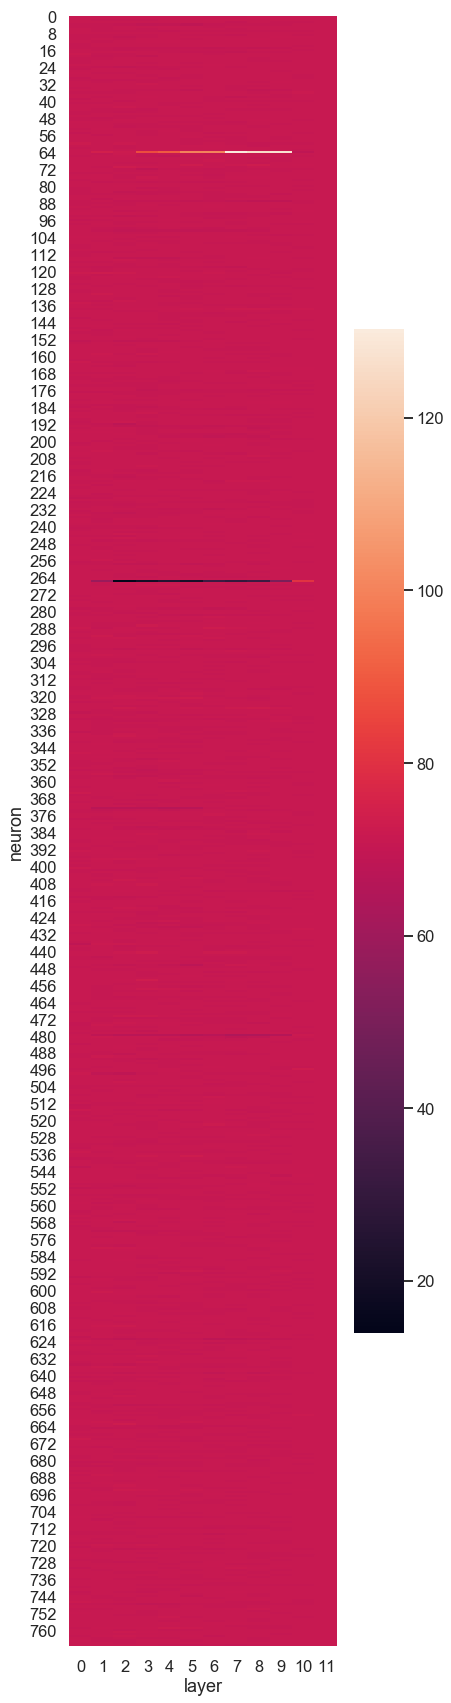

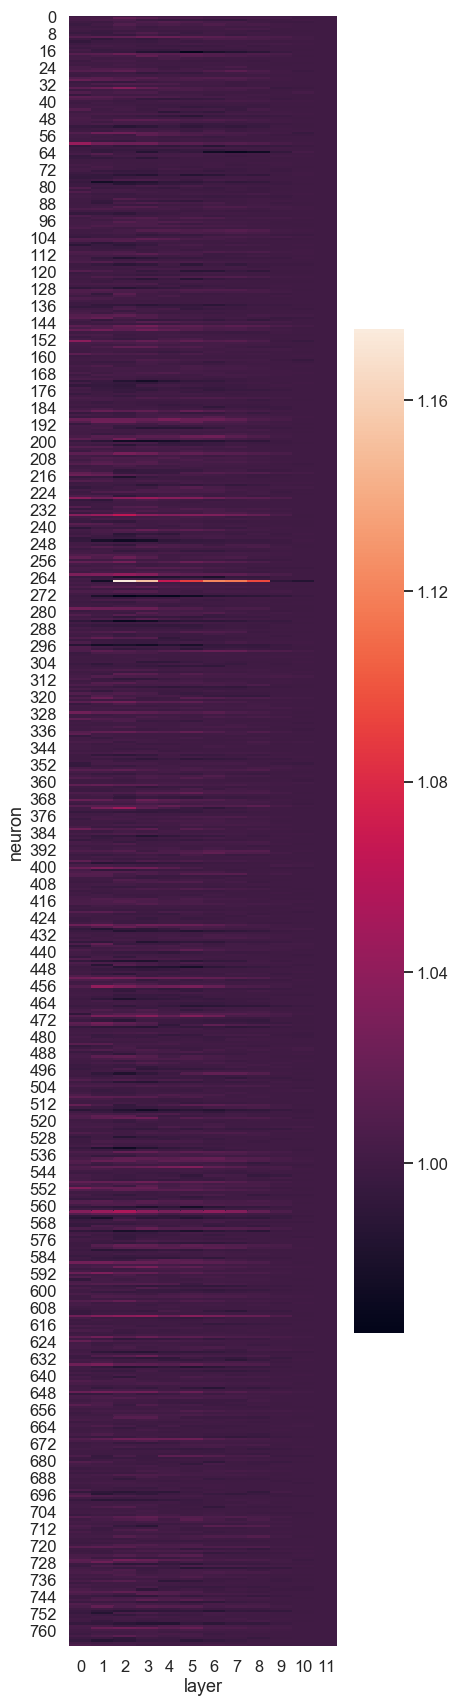

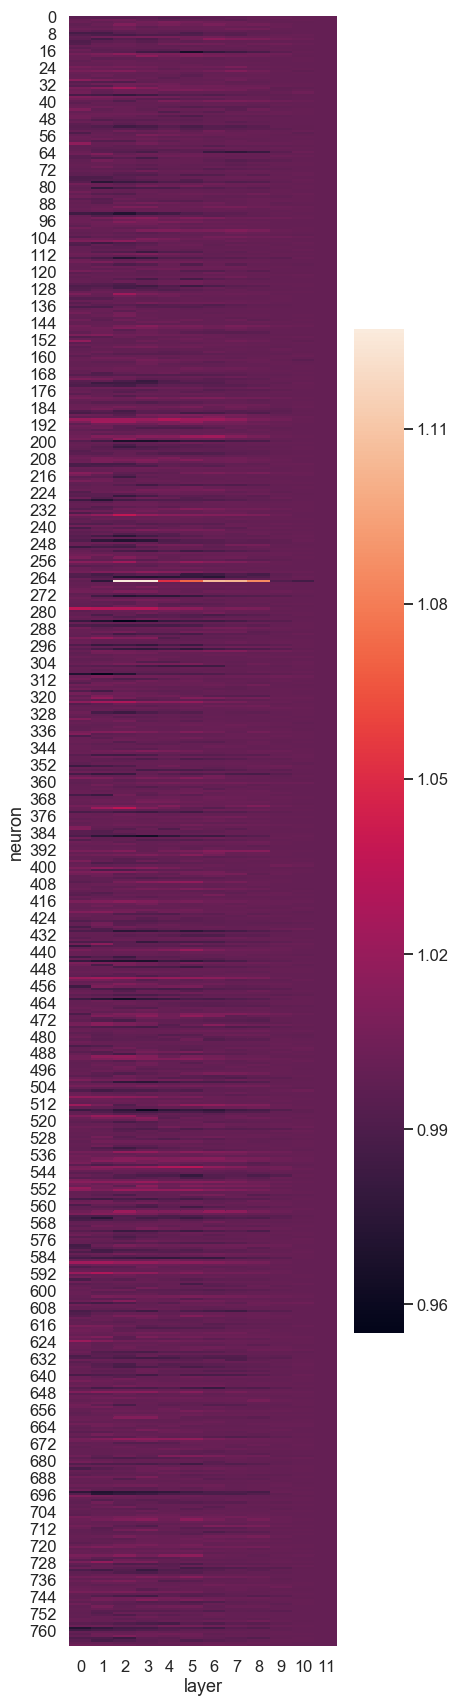

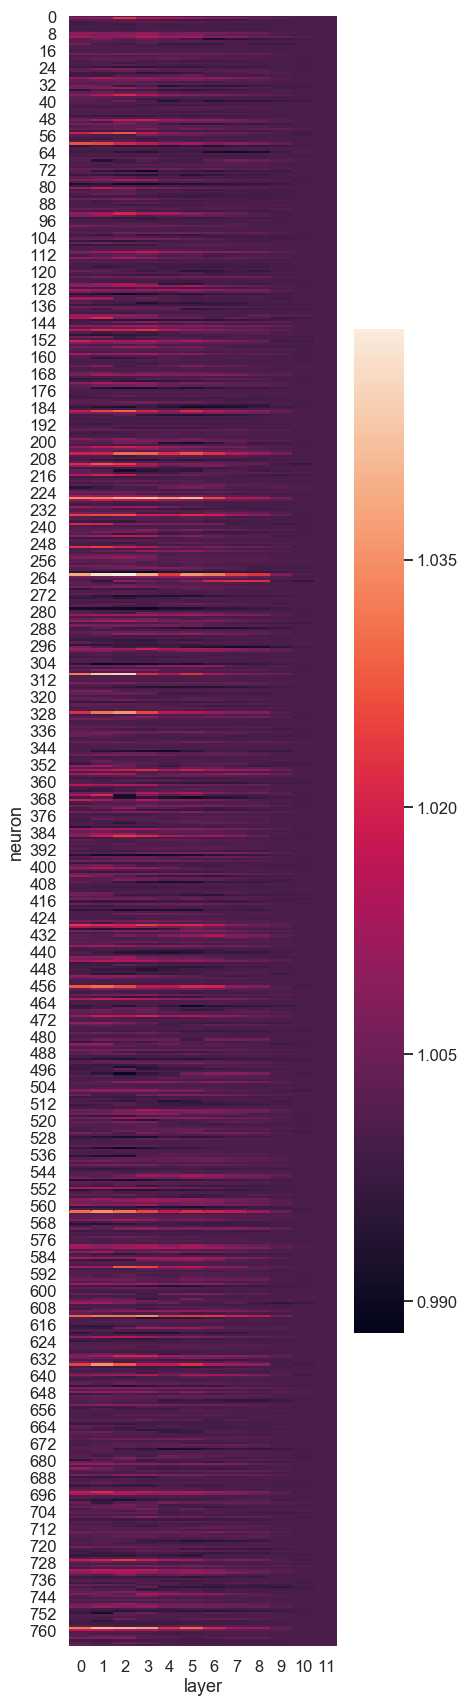

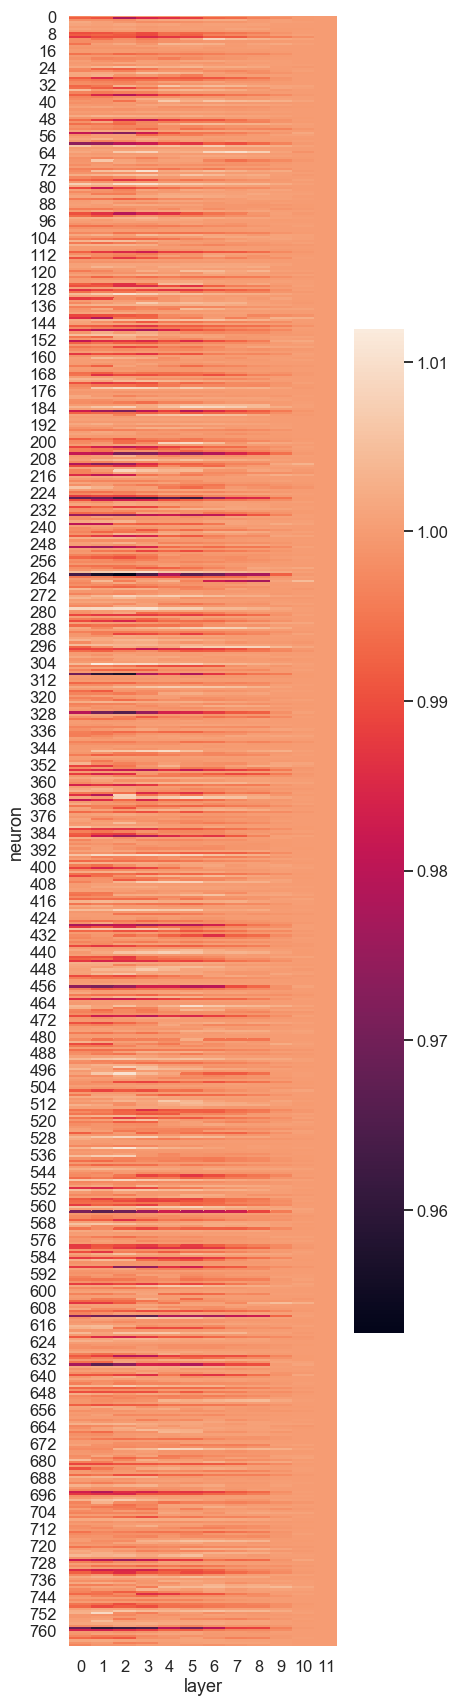

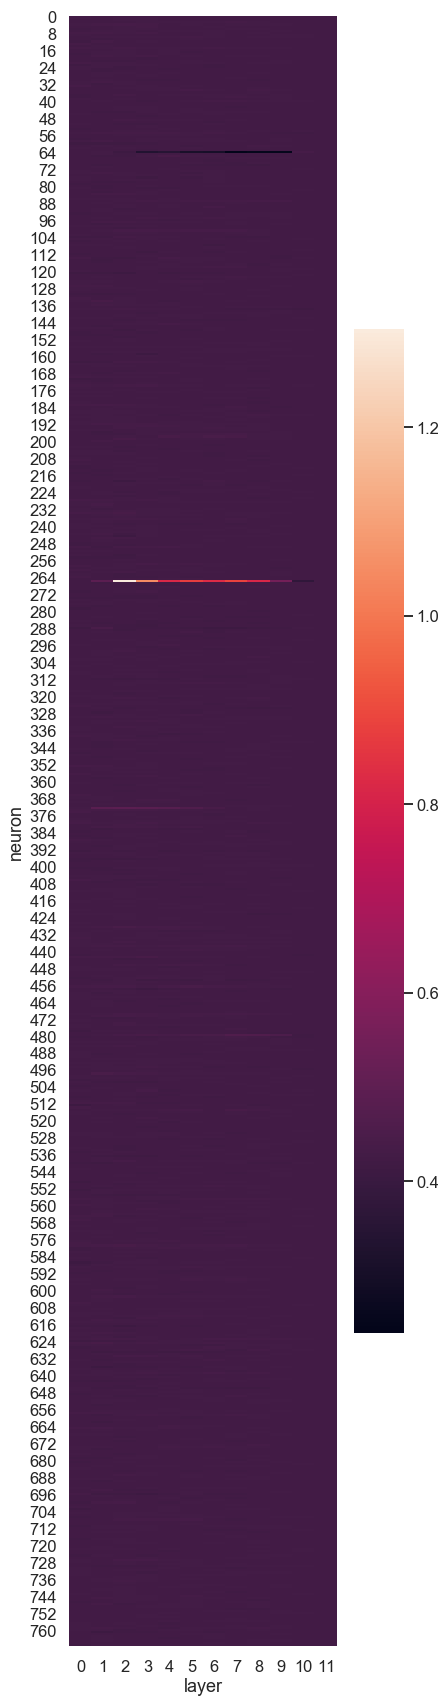

In [27]:
for p, name, mode in zip(paths, fnames, modes):
    results_df = pd.read_csv(p)
    analyze_effect_results(
        results_df, 
        mode, 
        'all', 
        'woman',
        savefig=folder_name + name + "_all_alpha1.pdf")

## Analysis of effects

In [56]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [76]:
df = pd.read_csv('results/20191003_neuron_intervention/man_minus_woman.csv')
# calculate odds
odds_base = df['candidate2_base_prob'] / df['candidate1_base_prob']
odds_intervention = df['candidate2_prob'] / df['candidate1_prob']
odds_ratio = odds_intervention / odds_base
df['odds_ratio'] = odds_ratio
quantiles = df.groupby('base_string')['odds_ratio'].max()#quantile(0.95)

In [77]:
fig = px.bar(pd.DataFrame(quantiles).reset_index().sort_values('odds_ratio'), 
             x='base_string', 
             y='odds_ratio',
             )
fig.show()
